# TechLab - Trading Algoritmico Pt.4.2

In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
from collections import Counter
import numpy as np
import pandas as pd
import datetime as dt
import pickle
from sklearn import svm, neighbors
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
from datetime import datetime
import backtrader as bt

Definisco funzione per aggiungere % di variazione del prezzo di uno specifico titolo nei 7 giorni successivi

In [2]:
def process_data_for_labels(ticker, path = 'Data/sp500_joined_closes.csv'):
    hm_days = 7
    df = pd.read_csv(path, index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    
    df.fillna(0, inplace=True)
    return tickers, df

Definisco funzione per assegnazione label in funzione della variazione di prezzo

In [3]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > 0.02:
            return 1
        if col < -0.02:
            return -1
    return 0

Definisco funzione per estrazione features e target

In [4]:
def extract_featuresets(ticker, path = 'Data/sp500_joined_closes.csv'):
    tickers, df = process_data_for_labels(ticker, path)
    
    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                              df['{}_1d'.format(ticker)],
                                              df['{}_2d'.format(ticker)],
                                              df['{}_3d'.format(ticker)],
                                              df['{}_4d'.format(ticker)],
                                              df['{}_5d'.format(ticker)],
                                              df['{}_6d'.format(ticker)],
                                              df['{}_7d'.format(ticker)]
                                             ))
    
    
    # stampo la distribuzione delle label
    
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:', Counter(str_vals))
    
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    # definisco la matrice dei fattori: ogni colonna deve
    # contenere i returns (ossia la {}_1d) di ogni tiker.
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X, y, df

In [5]:
X, y, df = extract_featuresets('AAPL', path = 'Data/sp500_joined_closes.csv')
X_t, y_t, df_t = extract_featuresets('AAPL', path = 'Data/sp500_joined_closes_new.csv')

Data spread: Counter({'1': 2214, '-1': 1889, '0': 425})
Data spread: Counter({'1': 190, '-1': 137, '0': 59})


In [6]:
print(df_t)

                   MMM        ABT        ABBV        ABMD         ACN  \
Date                                                                    
2018-01-02  226.040421  57.017735   90.957497  192.490005  149.871857   
2018-01-03  226.030838  57.143818   92.380867  195.820007  150.563538   
2018-01-04  228.985367  57.046833   91.854034  199.250000  152.346329   
2018-01-05  230.769608  57.211708   93.453026  202.320007  153.603058   
2018-01-08  230.021362  57.046833   91.955704  207.800003  154.830551   
2018-01-09  231.450653  57.143818   92.648895  209.759995  155.346878   
2018-01-10  231.316360  57.056526   92.140572  208.139999  154.801331   
2018-01-11  232.438721  57.446327   92.410522  210.149994  155.005905   
2018-01-12  234.510712  57.339134   93.406586  215.110001  155.980118   
2018-01-16  234.769714  56.949337   95.408028  218.089996  153.885574   
2018-01-17  238.002441  57.485310   97.148811  224.130005  156.077530   
2018-01-18  235.892059  57.563267   96.636810  225.

In [7]:
print(X_t)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.23929468e-05  2.21130101e-03  1.56487416e-02 ...  4.14900324e-03
   2.77400876e-02 -4.81649293e-03]
 [ 1.30713527e-02 -1.69720657e-03 -5.70283217e-03 ... -7.51640123e-03
  -1.40689740e-02  8.06642760e-03]
 ...
 [ 2.54377853e-02 -1.79051941e-02  1.56763023e-03 ...  9.76378789e-03
  -9.30994002e-03  7.03217749e-03]
 [-2.88450450e-03 -1.31077947e-03 -1.42318389e-04 ... -5.06016901e-03
   3.02169575e-03  2.19834689e-03]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 ... -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]]


In [8]:
print(y)

[-1 -1 -1 ...  0  0  0]


Effettuo il train del modello e verifichiamo l'accuratezza dello stesso sui prezzi a partire dal 2 gennaio

In [9]:
def do_ml(ticker):
    # X, y, df = extract_featuresets(ticker)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    
    X_train, y_train, df = extract_featuresets(ticker, path = 'Data/sp500_joined_closes.csv')
    X_test, y_test, df_test = extract_featuresets(ticker, path = 'Data/sp500_joined_closes_new.csv')
    
    clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                           ('knn', neighbors.KNeighborsClassifier()),
                           ('rfor', RandomForestClassifier())])
    
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print('Accuracy:', confidence)
    predictions = clf.predict(X_test)
    print('Predict spread:', Counter(predictions))
    
    return confidence, predictions, clf

confidence, predictions, clf = do_ml('AAPL')

Data spread: Counter({'1': 2214, '-1': 1889, '0': 425})
Data spread: Counter({'1': 190, '-1': 137, '0': 59})


/home/techlab/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.41450777202072536
Predict spread: Counter({1: 197, -1: 181, 0: 8})


In [10]:
with open("Data/model.pickle","wb") as m:
    pickle.dump(clf, m)
df_predictions = pd.DataFrame(index = df_t.index, data = {'Prediction': predictions})
with open("Data/predictions.pickle","wb") as f:
    pickle.dump(df_predictions, f)
df_predictions.at['2018-01-02','Prediction']

-1

<IPython.core.display.Javascript object>


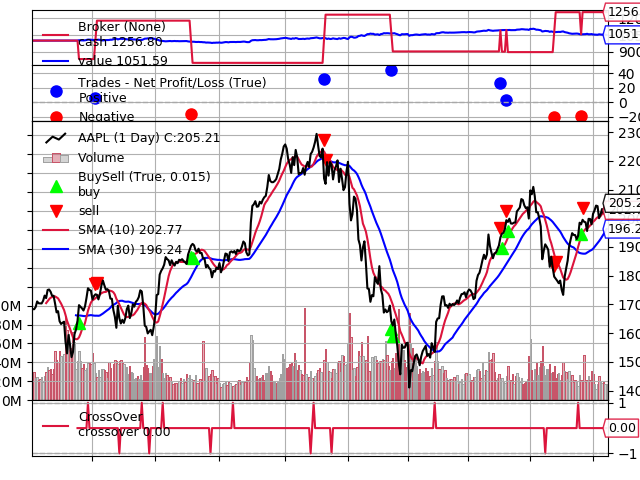

[[<Figure size 640x480 with 5 Axes>]]

In [11]:
# Creazione di una sottoclasse della Strategia per la definizione degli indicatori e della logica

class TechLabStrategy(bt.Strategy):
    # lista dei parametri configurabili nella strategia
    params = dict(
        pfast=10,  # periodo della fast moving average
        pslow=30   # periodo della slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # segnale di crossover
        with open("Data/predictions.pickle","rb") as f: # carico il modello trainato
            df_predictions = pickle.load(f)
        
    def next(self):
        tempo = self.data.datetime.date()
        tempo = tempo.strftime("%Y-%m-%d")
        prediction = df_predictions.at[tempo,'Prediction']
        
        if not self.position:  # non nel mercato
            #if (self.crossover > 0):  # se la fast MA incrocia la slow MA verso l'alto
            #if (prediction > 0 and self.crossover > 0):  # se la fast MA incrocia la slow MA verso l'alto e il modello stima long
            if (prediction > 0): # se il modello trainato predice long
                self.buy()  # entera long
            if (prediction < 0): # se il modello trainato predice short
                self.sell()  # entera short
        elif (prediction == 0): # se nel mercato & prediction è stazionaria
        #elif (self.crossover < 0):  # se nel mercato & l'incrocio delle MA avviene dal basso
            self.close()  # chiudi posizione long
            
cerebro = bt.Cerebro()  # avvio di un'istanza del motore "Cerebro"

# Data feed on-line
#data = bt.feeds.YahooFinanceData(dataname='AAPL',
#                                 fromdate=datetime(2018, 1, 2),
#                                 todate=datetime(2019, 7, 16))

# Data feed off-line
data = bt.feeds.YahooFinanceCSVData(dataname="Data/AAPL.csv")

cerebro.adddata(data)  # Aggiunta del data feed
cerebro.broker.setcash(1000.0) # Ammontare con cui iniziare
cerebro.addstrategy(TechLabStrategy)  # Aggiunta della strategia di trading
cerebro.run()  # esecuzione
cerebro.plot()  # plot
